<a href="https://colab.research.google.com/github/Sabarinathan612/machine_learning_project/blob/main/Customer_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unsupervised Model**
# K-Means Clustering
   - Customer segmentation based on purchasing behavior.

# Importing necessary libraries
Necessary libraries are imported for data manipulation (Pandas, Numpy), deep learning (PyTorch), plotting (Matplotlib), and preprocessing (Sklearn).



In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn # Neural Networks
import torch.optim as optim # Optimization algorithm used to optimise parameters from nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder #oneHotEncoder used to convert categoricial value into a binary format
from sklearn.compose import ColumnTransformer #ColumnTransformer is used to apply different transformers to different columns of an array or dataframes
from sklearn.pipeline import Pipeline #reduces code redundancy, and improves the reproducibility


# Reading the Data
The dataset is loaded from a CSV file into a Pandas DataFrame. This dataset contains customer information, including their ID, gender, age, annual income, and spending score.

In [ ]:
data = pd.read_csv('/content/Mall_Customers.csv')

# Data Analysis

In [ ]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
data.tail()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18
199,200,Male,30,137,83


In [ ]:
data.shape

(200, 5)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [ ]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

# Data Processing

In [ ]:
data = data.drop('CustomerID', axis=1)

In [ ]:
categorical_features = ['Gender']
numeric_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

preprocessor = ColumnTransformer(       #Used to categorise different columns
    transformers=[
        ('num', StandardScaler(), numeric_features),  #standard scalar is imported from sklearn to ensure numeric features
        ('cat', OneHotEncoder(), categorical_features)  #used to transform the categorical values
    ])

In [ ]:
data_processed = preprocessor.fit_transform(data) #previously defined (ColumnTransformer) to transform your data into processed format

# Convert Data to Tensors

In [ ]:
data_tensor = torch.FloatTensor(data_processed)#converts the preprocessed data (data_processed) into a PyTorch

# K-Means Clustering Implementation

In [ ]:
# K-Means Clustering in PyTorch
class KMeans(nn.Module):
    def __init__(self, n_clusters, n_features): #n_clusters: Stores the number of clusters as an attribute of the class
        super(KMeans, self).__init__()
        self.n_clusters = n_clusters #self.centroids: Defines centroids as a learnable parameter using nn.Parameter
        self.centroids = nn.Parameter(torch.randn(n_clusters, n_features))

    def forward(self, x):#The forward method provided is a crucial part of implementing the K-Means clustering algorithm
        # Compute the distance between each point and each centroid
        distances = torch.cdist(x, self.centroids)
        # Assign each point to the nearest centroid
        cluster_assignments = torch.argmin(distances, dim=1)
        return cluster_assignments
#his method is responsible for updating the centroids based on the current assignments of data points to cluster
    def update_centroids(self, x, cluster_assignments):
        for i in range(self.n_clusters):
            points_in_cluster = x[cluster_assignments == i]
            if points_in_cluster.shape[0] > 0:
              self.centroids.data[i] = points_in_cluster.mean(dim=0)

In [ ]:

n_clusters = 5  #In this case, it's set to 5 clusters.
n_features = data_tensor.shape[1]
kmeans = KMeans(n_clusters, n_features)

In [ ]:
# Training parameters
n_epochs = 100 #An epoch refers to one complete pass through the entire dataset during the training process.
optimizer = optim.SGD(kmeans.parameters(), lr=0.01) #SGD: Stands for Stochastic Gradient Descent, which is a popular optimization algorithm used for training machine learning models.

In [ ]:
#this section used  to satisfy various drawbacks that can be epoched
for epoch in range(n_epochs):
    optimizer.zero_grad()
    cluster_assignments = kmeans(data_tensor)
    kmeans.update_centroids(data_tensor, cluster_assignments)
    loss = ((data_tensor - kmeans.centroids[cluster_assignments]) ** 2).mean()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.3506
Epoch [20/100], Loss: 0.3506
Epoch [30/100], Loss: 0.3506
Epoch [40/100], Loss: 0.3506
Epoch [50/100], Loss: 0.3506
Epoch [60/100], Loss: 0.3506
Epoch [70/100], Loss: 0.3506
Epoch [80/100], Loss: 0.3506
Epoch [90/100], Loss: 0.3506
Epoch [100/100], Loss: 0.3506


In [ ]:
# Assign clusters to the original data
data['Cluster'] = cluster_assignments.numpy() #The right-hand side (cluster_assignments.numpy()) assigns the NumPy array (containing cluster labels) to this new column 'Cluster' in data.

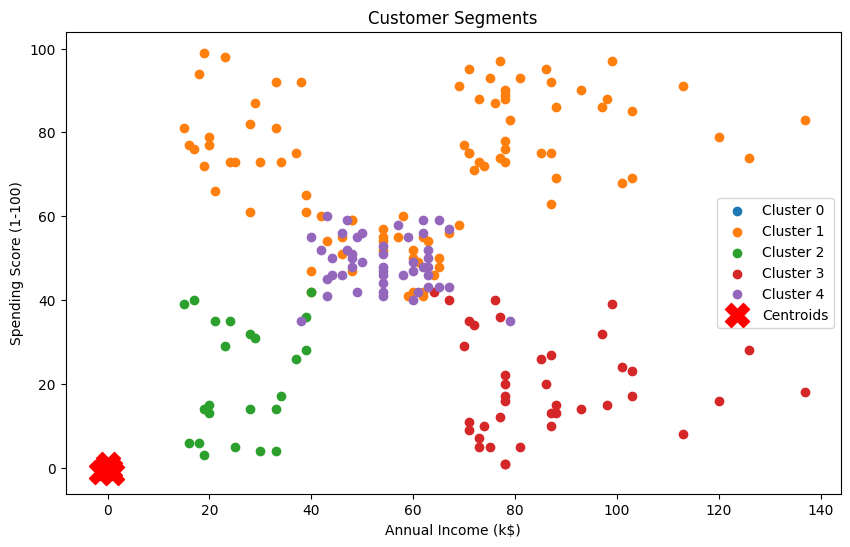

In [ ]:
# Visualize the clusters

gender_encoded = data_processed[:, len(numeric_features):]

plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_data = data[data['Cluster'] == i]
    plt.scatter(cluster_data['Annual Income (k$)'], cluster_data['Spending Score (1-100)'], label=f'Cluster {i}')
plt.scatter(kmeans.centroids.detach().numpy()[:, 1], kmeans.centroids.detach().numpy()[:, 2], s=300, c='red', label='Centroids', marker='X')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Customer Segments')
plt.legend()
plt.show()

# Pairplot

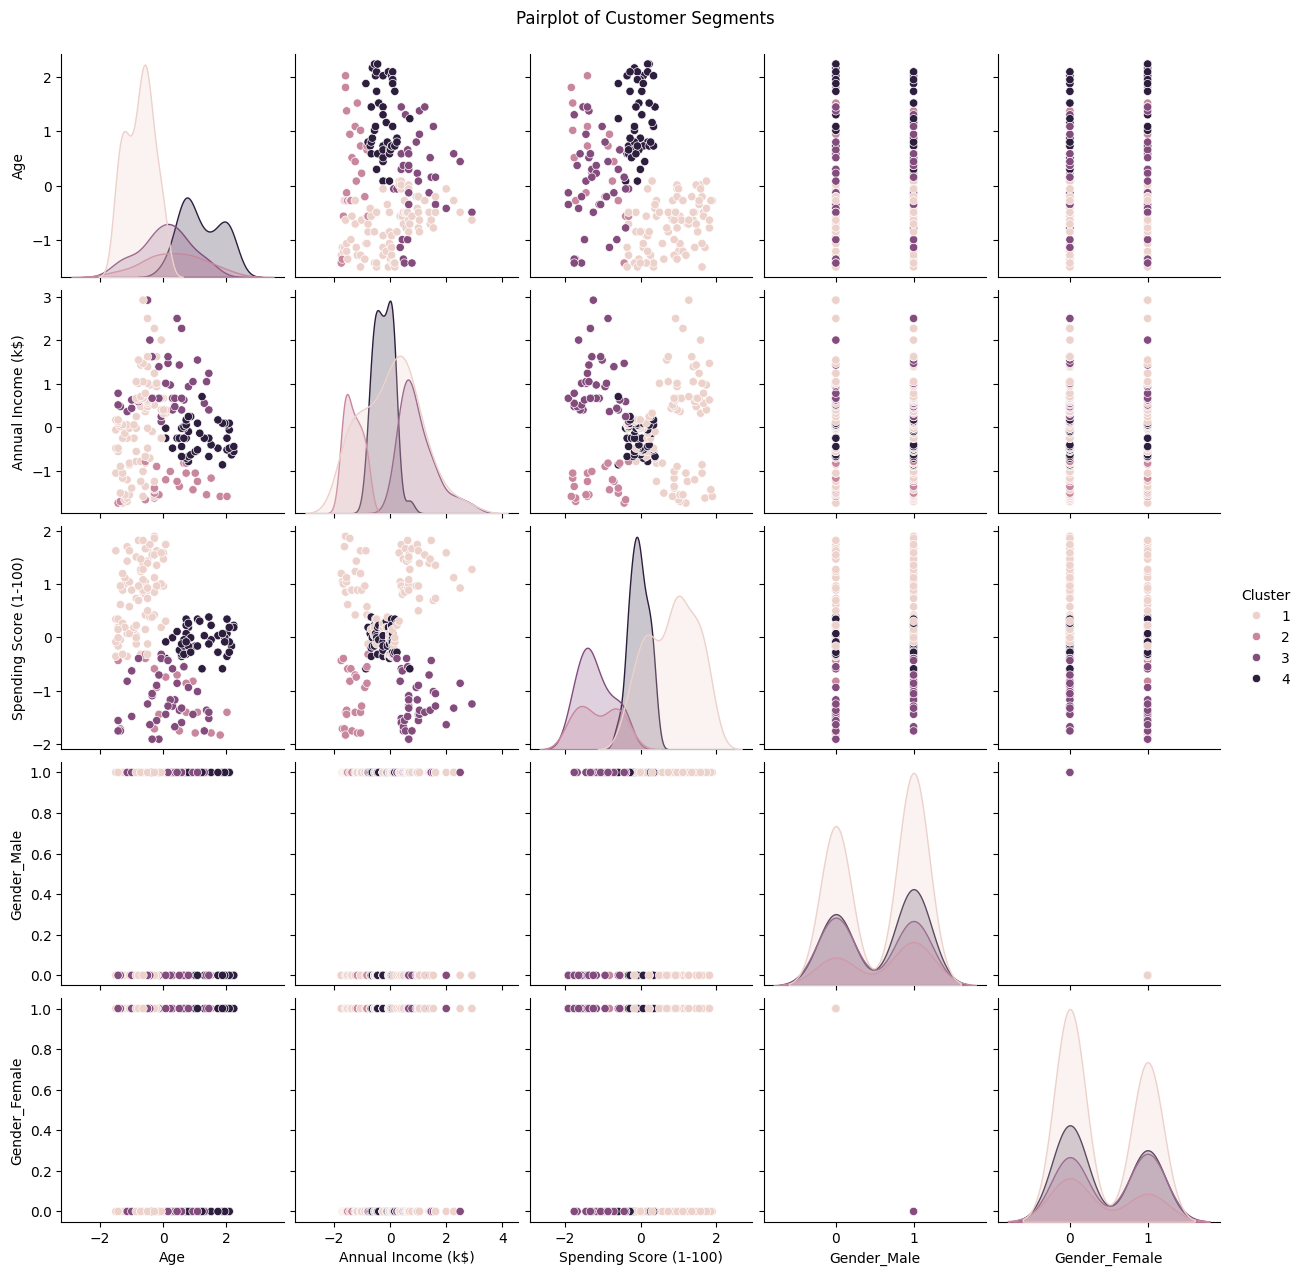

In [ ]:
import seaborn as sns

plot_data = pd.DataFrame(data_processed, columns=numeric_features + ['Gender_Male', 'Gender_Female'])
plot_data['Cluster'] = cluster_assignments.numpy()


sns.pairplot(plot_data, hue='Cluster', diag_kind='kde')
plt.suptitle('Pairplot of Customer Segments', y=1.02)
plt.show()


# 3D Scatter Plot

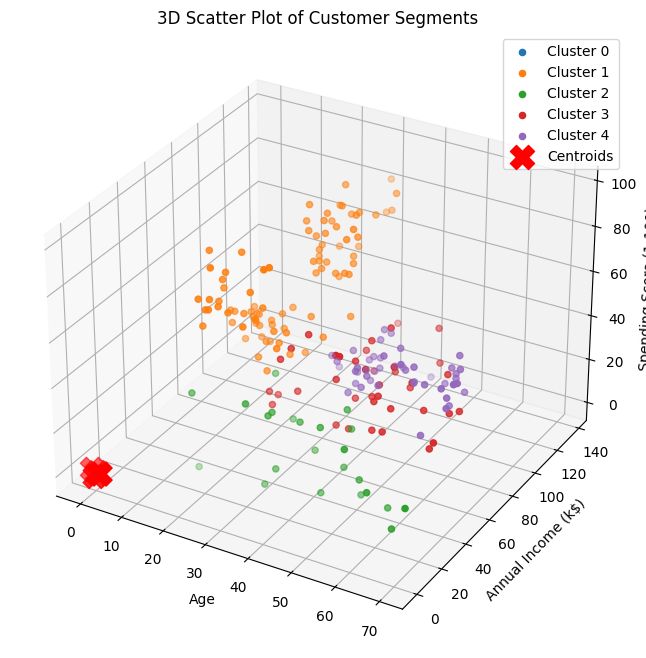

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(n_clusters):
    cluster_data = data[data['Cluster'] == i]
    ax.scatter(cluster_data['Age'], cluster_data['Annual Income (k$)'], cluster_data['Spending Score (1-100)'], label=f'Cluster {i}')


centroids = kmeans.centroids.detach().numpy()
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s=300, c='red', label='Centroids', marker='X')

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D Scatter Plot of Customer Segments')
ax.legend()
plt.show()


# Cluster Centers Plot

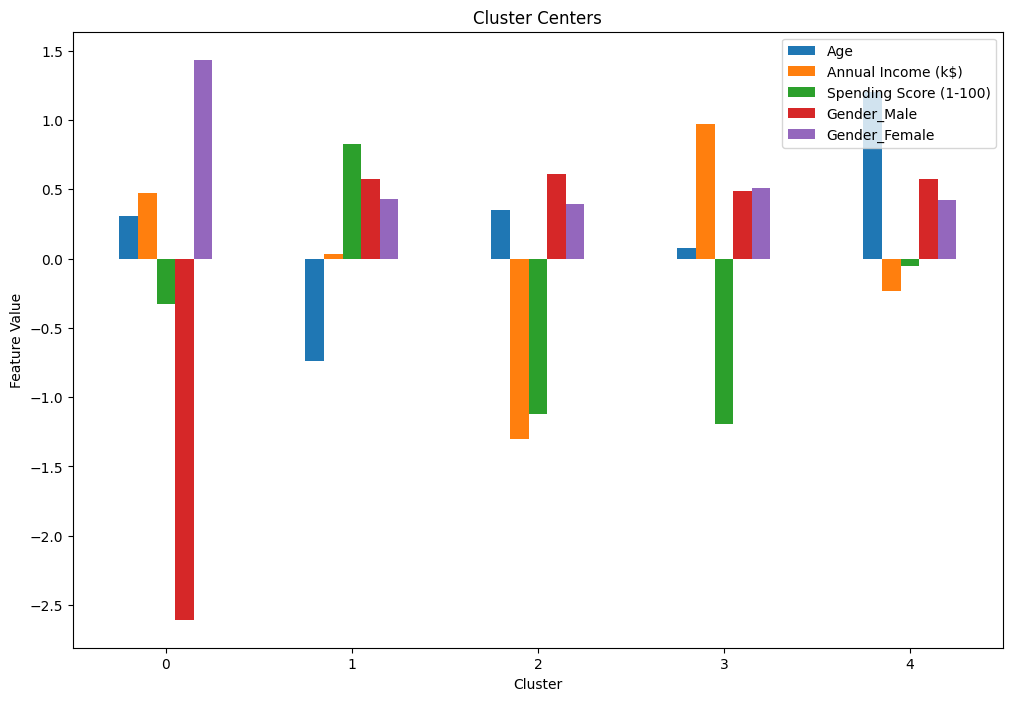

In [ ]:
centroids = kmeans.centroids.detach().numpy()
centroids_df = pd.DataFrame(centroids, columns=numeric_features + ['Gender_Male', 'Gender_Female'])

centroids_df.plot(kind='bar', figsize=(12, 8))
plt.title('Cluster Centers')
plt.xlabel('Cluster')
plt.ylabel('Feature Value')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()
